# Assignmnet 3

Read retweets csv file

In [1]:
import pandas as pd

#read file and put into data frame
df = pd.read_csv("retweets.csv")

#keep rows where lang == english
dfen = df[df["lang"] == "en"]

dfen.shape

(13796, 21)

Drop duplicates

In [2]:
dfen.drop_duplicates(subset ="origTweetId", keep = 'first', inplace = True) 
dfen.shape

C:\Users\sofia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(10834, 21)

Connect to twitter api

In [3]:
import tweepy

#configuration file
from twitter_config import config

#connecting to Twitter
auth = tweepy.OAuthHandler(config['consumer_key'], config['consumer_secret'])
auth.set_access_token(config['access_token'], config['access_token_secret'])

api = tweepy.API(auth,  wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

Create id search list

In [4]:
dfids = dfen["origTweetId"].astype(str).tolist()

Fetch tweets. In each loop get 100 tweets.

In [5]:
j = 0

tweet_text = []
for i in range(0, 108):
    tweet_text.append(api.statuses_lookup(dfids[j:j+100], map_=True))
    j+=100

tweet_text.append(api.statuses_lookup(dfids[j:len(dfids)+1], map_=True))

Get only the text portion of the tweet.

In [6]:
just_text = []
for item in tweet_text:
    for tweet in item:
        try:
            just_text.append(tweet.text)
        except:
            just_text.append(None)
len(just_text)

10834

In [14]:
text_clean

["lord hill's written answers to ep are now on my blog. no transparency on his lobbying past. shame!  ephearings2014",
 "our @sebdance asks @abratusek about global climate talks.'pls tell us how you will push a strong &amp; unified eu voice?' ",
 ".@ansip_eu agrees with @janalbrecht that opensource is a good way to improve trust in software's integrity. ephearings2014",
 'new:child abuse scandal manchester area - worse than rotherham @janecollinsmep @margotljparker @star_pumpkin ',
 'i write for @labourlist tory threat to court of humanrights "would replace rule of law with rule of mob."  @labourchr',
 '“@ashleyfoxmep: and named her party "the alliance of alenka bratusek! ephearings2014 mrs bratusek says bratusek',
 'good luck to @theprogressives in bulgaria today @eurolabour',
 "as ep does not provide coffee in meetings commissioner designate vestager has invited us for it. we'll approve her  vestager ephearing2014",
 "robert halfon raising issue of illegal traveller sites - if ukip h

Add the text in a new column

In [7]:
dfen["text"] = just_text
dfen = dfen.dropna(subset=["text"], axis = 0)

C:\Users\sofia\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Group by MEP member and keep those who have over 50 tweets

In [8]:
grouped = dfen.groupby(["origMepGroupShort"])["origMepName", "origUserId"].count()
filtered = grouped[grouped["origUserId"]>=50].reset_index()

In [9]:
dffinal = dfen[dfen["origMepGroupShort"].isin(filtered["origMepGroupShort"])]
dffinal.shape

(10107, 22)

## Clustering

Imports for the clustering section

In [11]:
import re
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from yellowbrick.cluster import InterclusterDistance

First some text transformations
* Convert to lowercase
* Remove urls from text

In [12]:
text_clean = []

#get the text into a list from dataframe
text = dffinal["text"].tolist()

for t in text:
    #use regular exression to strip url
    text_clean.append(re.sub(r'https?://\S+', '', t.replace("#", "")).lower())

Create and fit Vectorzer

In [20]:
vectorizer = CountVectorizer(strip_accents="unicode", stop_words='english', max_df=0.5, min_df=10)
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.5, max_features=None, min_df=10,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [21]:
matrix = vectorizer.fit_transform(text_clean)
matrix

<10107x1948 sparse matrix of type '<class 'numpy.int64'>'
	with 71936 stored elements in Compressed Sparse Row format>

Investigate for optimal number of clusters.
* Elbow method
* Silhouette score method

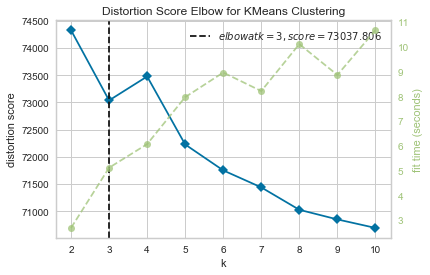

In [22]:
kmeans = KMeans(random_state=0)
visualizer = KElbowVisualizer(kmeans, k=(2, 11))

visualizer.fit(matrix)
visualizer.show()

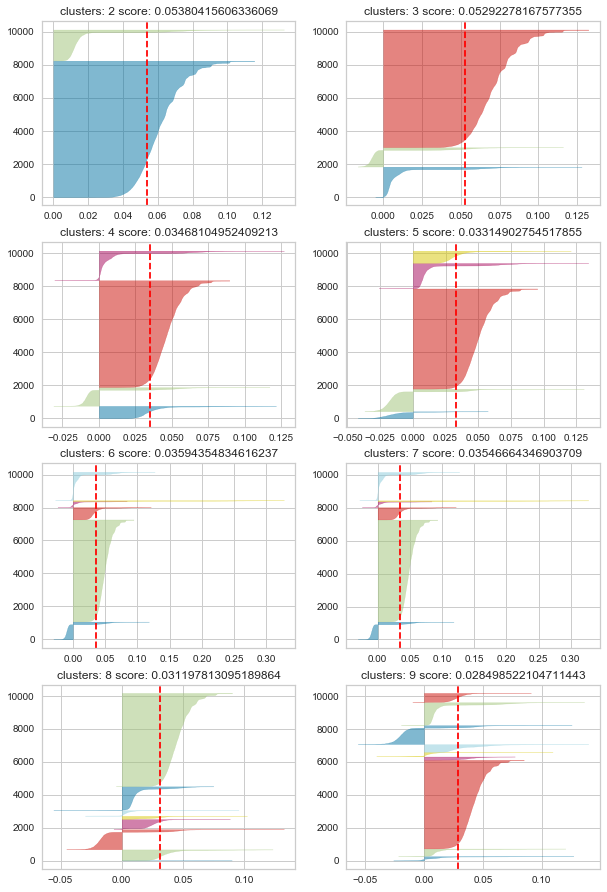

In [23]:
plt.figure(figsize=(2 * 5,  10 * 4))

scores = {}
for n_clusters in range(2, 10):
    plt.subplot(10, 2, n_clusters - 1)
    kmeans = KMeans(n_clusters, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    visualizer.fit(matrix)
    scores[n_clusters] = visualizer.silhouette_score_
    plt.title(f'clusters: {n_clusters} score: {visualizer.silhouette_score_}')

In [24]:
number_of_clusters=6
km = KMeans(n_clusters = number_of_clusters)
km.fit(matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [25]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :15]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: digital thanks market single great today work good europe europarl_en big michalboni discussion debate agenda
Cluster 1: meeting amp eppgroup today eu public good great ep european group europarl_en tonight migration epp
Cluster 2: amp eu eppgroup europe today meps need good european ttip people uk ep vote support
Cluster 3: eu uk leave cameron referendum today need britain vote meps people membership support european just
Cluster 4: european today europe eppgroup ep people ttip great parliament vote good new greece europarl_en support
Cluster 5: ukip vote labour today party nhs people amp immigration policy just uk lab debate mep


Although elbow diagram shows that the optimal number of clusters is 3, in the silhouette diagram we see that when choosing 3 clusters, we end up with disproportionate clusters. Also, in the second cluster there are a lot of words that are included in the cluster but should not have. By eliminating 2 and 3 clusters, the next best number is 6 based on silhouette score. There is still the large cluster but the rest are a lot more uniform.

Now for the meaning of the clusters:


Cluster 0: migration eu amp policy net ukip crisis europe need eppgroup>> Conservative or right parties involved


Cluster 1: today europe eppgroup ep great people good ttip vote new


Cluster 2: ukip vote labour today eu party nhs people amp immigration


Cluster 3: european parliament amp eu union gt just debate today eppgroup>>Related to votings or speeches in the parliament 


Cluster 4: eu uk leave cameron today referendum need britain vote meps >> Brexit related words


Cluster 5: amp eu eppgroup today good meps europe ttip need meeting


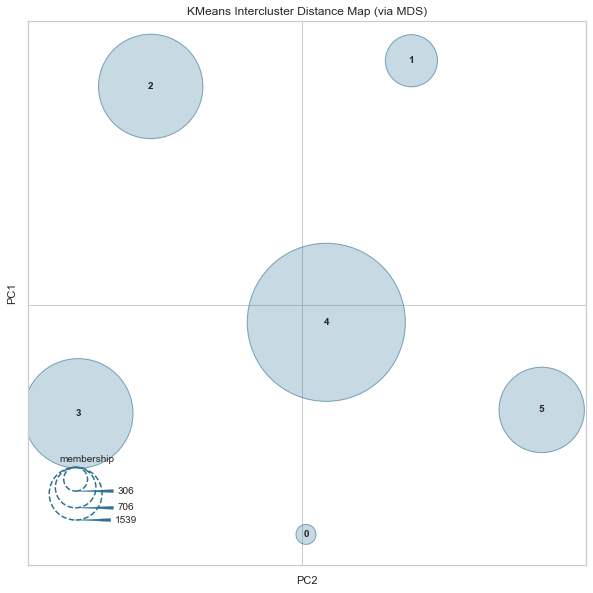

In [26]:
plt.figure(figsize=(10,10))

visualizer = InterclusterDistance(km)

visualizer.fit(matrix)
visualizer.show()

#### Classification

Imports for Classification section

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.dummy import DummyClassifier

Target variable y for our models will be the id of the Mep Group.
Training features x will de the tweet texts.

In [28]:
for i in range(0, len(text_clean)):
    text_clean[i] = re.sub(r'\b\w{1,7}\b', '', text_clean[i])

In [29]:
y = dffinal.origMepGroupId
x = text_clean

Split bag of words and y varible to train (70%) and test(30%) sets

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

* Classification with Multinomial NB

Setting different parameters to be checked

In [31]:
parameters = {'vect__min_df': [0, 0.001, 0.02],
              'vect__max_df': [0.4, 0.5, 0.6],
              'vect__token_pattern':['(?u)\\b\\w\\w+\\b','(?u)\\b\\w\\w\\w+\\b'],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (0.05, 0.1, 0.15, 0.2)
             }

Pipeline

In [32]:
text_clf = Pipeline([('vect', CountVectorizer(strip_accents="unicode", stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', MultinomialNB()),
                    ])

Grid search between parameters

In [33]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf = gs_clf.fit(x_train, y_train)
gs_clf_best = gs_clf.best_estimator_
gs_clf.best_params_

{'clf__alpha': 0.05,
 'tfidf__use_idf': True,
 'vect__max_df': 0.4,
 'vect__min_df': 0.02,
 'vect__token_pattern': '(?u)\\b\\w\\w+\\b'}

In [34]:
gs_clf_best.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.4,
                                 max_features=None, min_df=0.02,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents='unicode',
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 MultinomialNB(alpha=0.05, class_prior=None, fit_prior=True))],
         verbose=False)

In [36]:
predicted = gs_clf_best.predict(x_test)

print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.23      0.04      0.07       689
           2       0.00      0.00      0.00       292
           3       0.00      0.00      0.00       430
           4       0.00      0.00      0.00       484
           5       0.00      0.00      0.00       293
           6       0.25      0.96      0.40       770

    accuracy                           0.25      3033
   macro avg       0.07      0.14      0.07      3033
weighted avg       0.12      0.25      0.12      3033



* Classification with SGV

Setting different parameters to be checked

In [37]:
parameters = {'vect__min_df': [5, 10, 15],
              'vect__max_df': [0.25, 0.5, 0.75],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (0.001, 0.003, 0.006),
             }

Pipeline

In [38]:
text_clf_1 = Pipeline([('vect', CountVectorizer(strip_accents="unicode", stop_words='english')),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge',  penalty='l2', random_state=42)),
                    ])

Grid search between parameters

In [39]:
gs_clf_1 = GridSearchCV(text_clf, parameters, n_jobs=-1, cv=5)
gs_clf_1 = gs_clf_1.fit(x_train, y_train)
gs_clf_best_1 = gs_clf_1.best_estimator_
gs_clf_1.best_params_

{'clf__alpha': 0.001,
 'tfidf__use_idf': True,
 'vect__max_df': 0.25,
 'vect__min_df': 15}

In [40]:
gs_clf_best_1.fit(x_train, y_train)
predicted_1 = gs_clf_best_1.predict(x_test)

print(metrics.classification_report(y_test, predicted_1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        75
           1       0.25      0.32      0.28       689
           2       0.04      0.00      0.01       292
           3       0.13      0.03      0.04       430
           4       0.16      0.04      0.07       484
           5       0.16      0.01      0.03       293
           6       0.28      0.67      0.39       770

    accuracy                           0.26      3033
   macro avg       0.14      0.15      0.12      3033
weighted avg       0.19      0.26      0.18      3033



Trying the Dummy Classifier. As per expected score is too low, with 25% accuracy

In [41]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(x_train, y_train)
dummy_clf.score(x_test, y_test)

0.25387405209363667